Calculated Ranges for file 0: {'S0': (1886.0, 2010.8999999999999), 'S1': (1861.0, 1975.0), 'S2': (1892.0, 1975.0), 'S3': (1861.0, 1943.0)}
Calculated Ranges for file 1: {'S0': (1937.0, 2134.0), 'S1': (1892.0, 2089.35), 'S2': (1899.0, 2034.1), 'S3': (1823.0, 1892.0)}
Calculated Ranges for file 2: {'S0': (1905.0, 2111.85), 'S1': (1810.0, 2004.5499999999997), 'S2': (1905.0, 2064.0), 'S3': (1816.0, 1846.2)}
Calculated Ranges for file 3: {'S0': (2064.0, 2749.4000000000005), 'S1': (1877.9, 2271.1), 'S2': (2031.7, 2877.6499999999996), 'S3': (1823.0, 1867.0)}


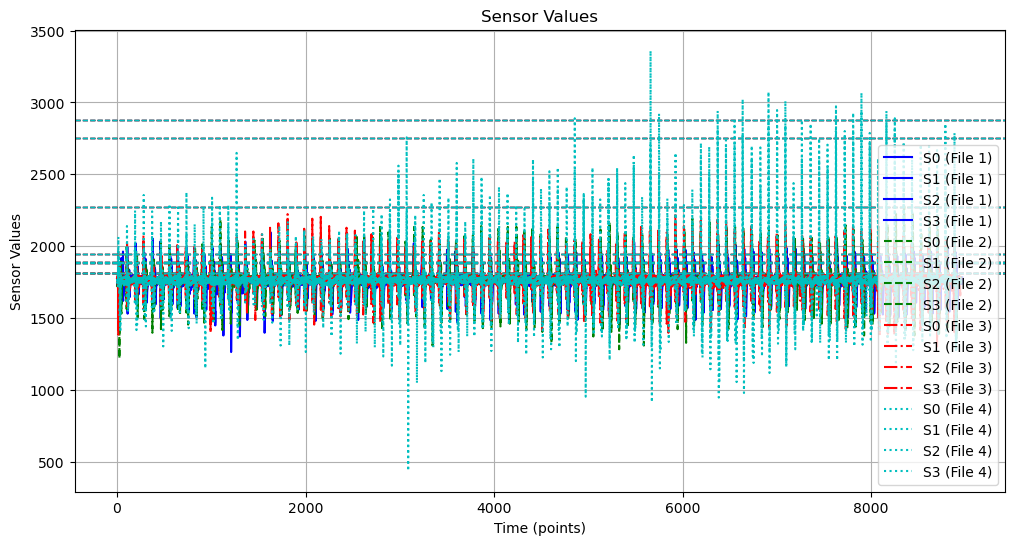

In [4]:
import tkinter as tk
from tkinter import filedialog, messagebox
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg, NavigationToolbar2Tk
from collections import defaultdict

class SensorAnalyzer:
    def __init__(self, master):
        self.master = master
        self.master.title("CSV File Opener")
        
        self.column_names = ['S0', 'S1', 'S2', 'S3']
        self.selected_sensors = {name: tk.BooleanVar(value=True) for name in self.column_names}
        
        self.filepaths = []
        self.data = []
        self.ranges = defaultdict(dict)
        
        self.create_widgets()
        
    def create_widgets(self):
        btn_open = tk.Button(self.master, text="Open CSV Files", command=self.open_files)
        btn_open.pack(pady=10)
        
        self.checkbox_frame = tk.Frame(self.master)
        self.checkbox_frame.pack()
        
        for sensor in self.column_names:
            chk = tk.Checkbutton(self.checkbox_frame, text=sensor, variable=self.selected_sensors[sensor], command=self.update_plot)
            chk.pack(side=tk.LEFT)
        
        self.plot_frame = tk.Frame(self.master)
        self.plot_frame.pack(fill=tk.BOTH, expand=True)
        
        self.canvas = None
        self.toolbar = None
    
    def open_files(self):
        self.filepaths = filedialog.askopenfilenames(filetypes=[("CSV files", "*.csv")])
        if not self.filepaths:
            return
        
        self.data = [pd.read_csv(filepath) for filepath in self.filepaths]
        for i, df in enumerate(self.data):
            df.columns = self.column_names
            self.calculate_ranges(df, i)
        
        self.ai_analysis()  # 进行 AI 分析，生成新的状态范围
        
        self.update_plot()
    
    def calculate_ranges(self, df, index):
        for sensor in self.column_names:
            baseline = df[sensor].median()
            std_dev = df[sensor].std()
            threshold = baseline + 2 * std_dev
            
            impulses = df[sensor][df[sensor] > threshold]
            if not impulses.empty:
                lower = impulses.quantile(0.05)
                upper = impulses.quantile(0.95)
                self.ranges[index][sensor] = (lower, upper)
            else:
                self.ranges[index][sensor] = (baseline, baseline)
        print(f"Calculated Ranges for file {index}:", self.ranges[index])
    
    def ai_analysis(self):
        # 这里简化为一个基本的规则来示范，实际上应该用更复杂的 AI 模型或算法来分析数据
        for sensor in self.column_names:
            overall_lower = min(self.ranges[i][sensor][0] for i in range(len(self.data)))
            overall_upper = max(self.ranges[i][sensor][1] for i in range(len(self.data)))
            self.ranges[0][sensor] = (overall_lower, overall_upper)
    
    def update_plot(self):
        if not self.filepaths:
            return
        
        if self.canvas:
            self.canvas.get_tk_widget().pack_forget()
            self.toolbar.pack_forget()
        
        fig, ax = plt.subplots(figsize=(12, 6))
        
        colors = ['b', 'g', 'r', 'c']
        linestyles = ['-', '--', '-.', ':']
        
        for i, df in enumerate(self.data):
            for sensor in self.column_names:
                if self.selected_sensors[sensor].get():
                    ax.plot(df[sensor], label=f'{sensor} (File {i+1})', color=colors[i % len(colors)], linestyle=linestyles[i % len(linestyles)], picker=5)
                    lower, upper = self.ranges[0][sensor]
                    ax.axhline(lower, color=colors[i % len(colors)], linestyle='--', linewidth=1)
                    ax.axhline(upper, color=colors[i % len(colors)], linestyle='--', linewidth=1)
        
        ax.set_title('Sensor Values')
        ax.set_xlabel('Time (points)')
        ax.set_ylabel('Sensor Values')
        ax.legend()
        ax.grid(True)
        
        fig.canvas.mpl_connect('pick_event', self.onpick)
        fig.canvas.mpl_connect('scroll_event', self.zoom)
        
        self.canvas = FigureCanvasTkAgg(fig, master=self.plot_frame)
        self.canvas.draw()
        self.canvas.get_tk_widget().pack(side=tk.TOP, fill=tk.BOTH, expand=True)
        
        self.toolbar = NavigationToolbar2Tk(self.canvas, self.plot_frame)
        self.toolbar.update()
        self.toolbar.pack(side=tk.TOP, fill=tk.BOTH, expand=True)
    
    def onpick(self, event):
        ind = event.ind
        sensor_data = ""
        for i in ind:
            sensor_data += f"{event.artist.get_label()}: {event.artist.get_ydata()[i]}\n"
        messagebox.showinfo("Sensor Data", sensor_data)
    
    def zoom(self, event):
        base_scale = 1.1
        ax = event.inaxes
        cur_xlim = ax.get_xlim()
        cur_ylim = ax.get_ylim()
        xdata = event.xdata
        ydata = event.ydata
        if event.button == 'up':
            scale_factor = 1 / base_scale
        elif event.button == 'down':
            scale_factor = base_scale
        else:
            scale_factor = 1
        
        new_width = (cur_xlim[1] - cur_xlim[0]) * scale_factor
        new_height = (cur_ylim[1] - cur_ylim[0]) * scale_factor
        
        relx = (cur_xlim[1] - xdata) / (cur_xlim[1] - cur_xlim[0])
        rely = (cur_ylim[1] - ydata) / (cur_ylim[1] - cur_ylim[0])
        
        ax.set_xlim([xdata - new_width * (1 - relx), xdata + new_width * relx])
        ax.set_ylim([ydata - new_height * (1 - rely), ydata + new_height * rely])
        ax.figure.canvas.draw()

root = tk.Tk()
app = SensorAnalyzer(root)
root.mainloop()
